### CORRECCIÓN DE OUTLIER POR DOS MÉTODOS DIFERENTES

In [1]:
ruta = "G:/PhD/Datos SIATA/Análisis/Descriptivo/"

In [2]:
import numpy as np
np.random.seed(4)
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import tensorflow as tf

pd.options.mode.chained_assignment = None  # default='warn' --- Para quitar los warnings de pandas y python
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR) # Quitar warnings tensorflow

archivo = "DF"
sensor = "pm25"
datos = pd.read_csv(ruta+"test_"+archivo+"_outliers.csv",sep=",")
entreno = pd.read_csv(ruta+"nodos_entrenamiento_sin_outliers_"+archivo+".csv",sep=",")


#datos[sensor] = pd.Series([round(val,0) for val in datos[sensor]])

In [3]:
# 2. FUNCIONES AUXILIARES ********************

# 2.1 Función que corrige el valor identificado como outlier. Lo que se hace es sacar el promedio de las últimas 
# 10 diferecnias y sumarlo al valor anterior al outlier. Ese será el nuevo valor.

def corregir(variable,dif):
    if (variable[k] - variable [k-1]) >= 0:
        valor = variable[k-1] + abs(np.mean(dif))
    else:
        valor = variable[k-1] - abs(np.mean(dif))
    
    if valor < 0:
        valor = 0
    
    return round(valor,4)

def entrena_modelo(set_entrenamiento_escalado, time_step, na, dim_salida, epochs, batch_size):

    X_train = []
    Y_train = []
    m = len(set_entrenamiento_escalado)

    for i in range(time_step,m):
        X_train.append(set_entrenamiento_escalado[i-time_step:i,0])
        Y_train.append(set_entrenamiento_escalado[i,0])
    
    X_train, Y_train = np.array(X_train), np.array(Y_train)
    
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

    dim_entrada = (X_train.shape[1],1)
    
    modelo = Sequential()
    modelo.add(LSTM(units=na, input_shape=dim_entrada))
    modelo.add(Dense(units=dim_salida))
    modelo.compile(optimizer='rmsprop', loss='mse', metrics='accuracy')
    #modelo.fit(X_train,Y_train,epochs=epochs,batch_size=batch_size,verbose=0,shuffle=False,validation_split=0.1)
    history = modelo.fit(X_train,Y_train,epochs=epochs,batch_size=batch_size,verbose=0,shuffle=False,validation_split=0.1)
    
    return modelo, history

def sets_validacion(datos, variable, d, time_step, sc):
    datos["fechaHora"] = datos["fecha"] + " " + datos["hora"]
    
    if d < time_step:
        time_step = d
    
    set_validacion = datos.iloc[[d-1,d]]
    set_validacion = set_validacion.loc[:,["fechaHora", variable]]
    set_validacion.set_index("fechaHora", inplace=True)
    
    set_entrenamiento = datos.loc[:,["fechaHora", variable]]
    pd.to_datetime(set_entrenamiento["fechaHora"])
    set_entrenamiento.set_index("fechaHora", inplace=True)
    
    x_test = np.concatenate((set_entrenamiento[d-time_step:d].values,set_validacion.values),axis=0)
    x_test = sc.transform(x_test)
    
    return set_validacion, x_test
    
    
def RNN(modelo, x_test, time_step, d):

    X_test = []
    
    if d < time_step:
        time_step = d

    for i in range(time_step,len(x_test)):
        X_test.append(x_test[i-time_step:i,0])

    X_test = np.array(X_test)
    
    #if d == 37581:
    #    print("Valor de i:",i,"**** Valor de longitud:",len(x_test))
    #    print("Valor de d:",d, "******", X_test,"****",x_test)
        
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

    prediccion = modelo.predict(X_test)
    prediccion = sc.inverse_transform(prediccion)
    
    return prediccion


def sets_entrenamiento(datos, variable):
    #set_entrenamiento_df, set_validacion_df = entrenamiento(datos, variable, tam_entre, d)
    #print(datos.head(10))
    
    #set_entrenamiento = datos.loc[datos.loc[:,"fecha"]!="2020-02-29"]
    datos["fechaHora"] = datos["fecha"] + " " + datos["hora"]
    set_entrenamiento = datos.loc[:,["fechaHora", variable]]
    pd.to_datetime(set_entrenamiento["fechaHora"])
    set_entrenamiento.set_index("fechaHora", inplace=True)
    
    sc = MinMaxScaler(feature_range=(0,1))
    set_entrenamiento_escalado = sc.fit_transform(set_entrenamiento)
    
    return set_entrenamiento, set_entrenamiento_escalado, sc

Nodo: 2 es el 1 de: 1 **********************
Tiempo Tendencia: 00:00:04.235016
Tiempo RNN: 00:34:07.009926
Tiempo de entrenamiento: 0:24:48.351807
Tiempo total: 0:34:13.735501


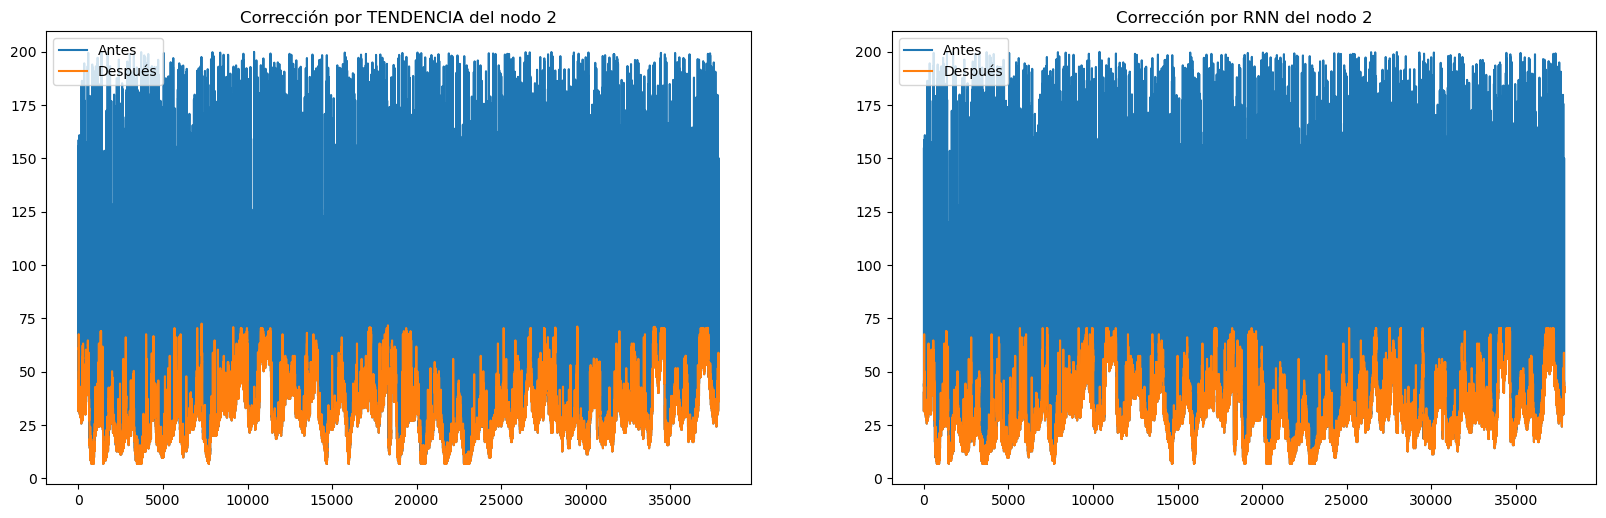

In [13]:
# 3. CORRECCIÓN DE LOS OUTLIERS
# Los outliers ya fueron identificados previamente por una técnica de identificación de outliers. 

# 3.1 Variables de ajuste.
#mem = 60 # Cantidad de valores en la memoria
time_step = 60 # Cantidad de datos de la memoria
na = 50 # Cantidad de neuronas
dim_salida = 1 # Datos de salida
epochs = 50 # Número de interacciones
batch_size = 32 # Tamaño de lote de datos

# Nodos de entrenamiento: 50, 134, 187, 266
nodo_entreno = 50
entrenamiento = entreno.loc[entreno.loc[:,"codigoSerial"] == nodo_entreno]

nodos = datos.codigoSerial.unique().tolist()
datos_corregidos = pd.DataFrame()
c = 0
now = datetime.now()
time_tendencia = datetime(now.year, now.month, now.day, 00, 00, 00, 00000)
time_rnn = datetime(now.year, now.month, now.day, 00, 00, 00, 00000)

# 3.2 Ciclo de recorrido por cada nodo
for n in nodos:
    inicio = datetime.now()
    c += 1
    print("Nodo:", n, "es el", c, "de:", len(nodos), "**********************")
    corregidos = datos.loc[datos.loc[:,"codigoSerial"] == n]
    
    corregidos[sensor+"_corr_ten"] = corregidos[sensor] # Duplico la columna de los datos para los corregidos
    corregidos[sensor+"_corr_RNN"] = corregidos[sensor]
    corregidos.reset_index(inplace=True, drop=True)  # Reinicia índice del DataFrame
    dif = []
    
    rnn_entrena = datetime.now()
    rnn_inicio = datetime.now()
#    entrenamiento = corregidos.loc[corregidos.loc[:,sensor+"_outlier"] == "N"]
    set_entrenamiento, set_entrenamiento_escalado, sc = sets_entrenamiento(entrenamiento, sensor)
    modelo, history = entrena_modelo(set_entrenamiento_escalado, time_step, na, dim_salida, epochs, batch_size)
    rnn_fin = datetime.now()
    time_rnn = time_rnn +(rnn_fin-rnn_inicio)
    rnn_fin_entrena = datetime.now()
    tiempo_entrenamiento = (rnn_fin_entrena-rnn_entrena)


# 3.3 Correción de outliers 
    for k in range(2,len(corregidos)):
        
        dif.append(corregidos[sensor][k-1]-corregidos[sensor][k-2])
        del(dif[0:-time_step])
        
        if (corregidos[sensor+"_outlier"][k] != "N"):
            
# CORRECCIÓN DE OUTLIER POR PROMEDIO DE DIFERENCIAS Y TENDENCIA
            ten_inicio = datetime.now()
            corregidos.loc[k,sensor+"_corr_ten"] = corregir(corregidos[sensor+"_corr_ten"],dif)
            #corregidos.loc[k,"pm25"] = corregir(corregidos[sensor],dif)
            #corregidos.loc[k,"pm25_corr"]= "S"
            ten_fin = datetime.now()
            time_tendencia = time_tendencia +(ten_fin-ten_inicio)

# CORRECCIÓN DE OUTLIERS POR RNN
            rnn_inicio = datetime.now()
            set_validacion, x_test = sets_validacion(corregidos, sensor+"_corr_RNN", k, time_step, sc)
                
            prediccion = RNN(modelo, x_test, time_step, k)
            corregidos.loc[k,sensor+"_corr_RNN"]= prediccion[0][0]
            #corregidos.loc[d,(variable+"_corr")]= "S"
            rnn_fin = datetime.now()
            time_rnn = time_rnn +(rnn_fin-rnn_inicio)


    
# 3.4 Almacenamiento de los datos corregidos en un dataframe    
    datos_corregidos = pd.concat([datos_corregidos,corregidos],ignore_index=True)
    
    fin = datetime.now()
    print("Tiempo Tendencia:", time_tendencia.time())
    print("Tiempo RNN:", time_rnn.time())
    print("Tiempo de entrenamiento:",tiempo_entrenamiento)
    print("Tiempo total:", fin-inicio)

# 3.5 Gráfico de los datos después de corregirlos
    
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,6), dpi=100)
    
    ax1.set_title("Corrección por TENDENCIA del nodo "+str(n))
    ax1.plot(datos_corregidos[sensor].tolist(), label="Antes")
    ax1.plot(datos_corregidos[sensor+"_corr_ten"].tolist(), label="Después")
    ax1.legend()
    
    ax2.set_title("Corrección por RNN del nodo "+str(n))
    ax2.plot(datos_corregidos[sensor].tolist(), label="Antes")
    ax2.plot(datos_corregidos[sensor+"_corr_RNN"].tolist(), label="Después")
    ax2.legend()    
    plt.show()

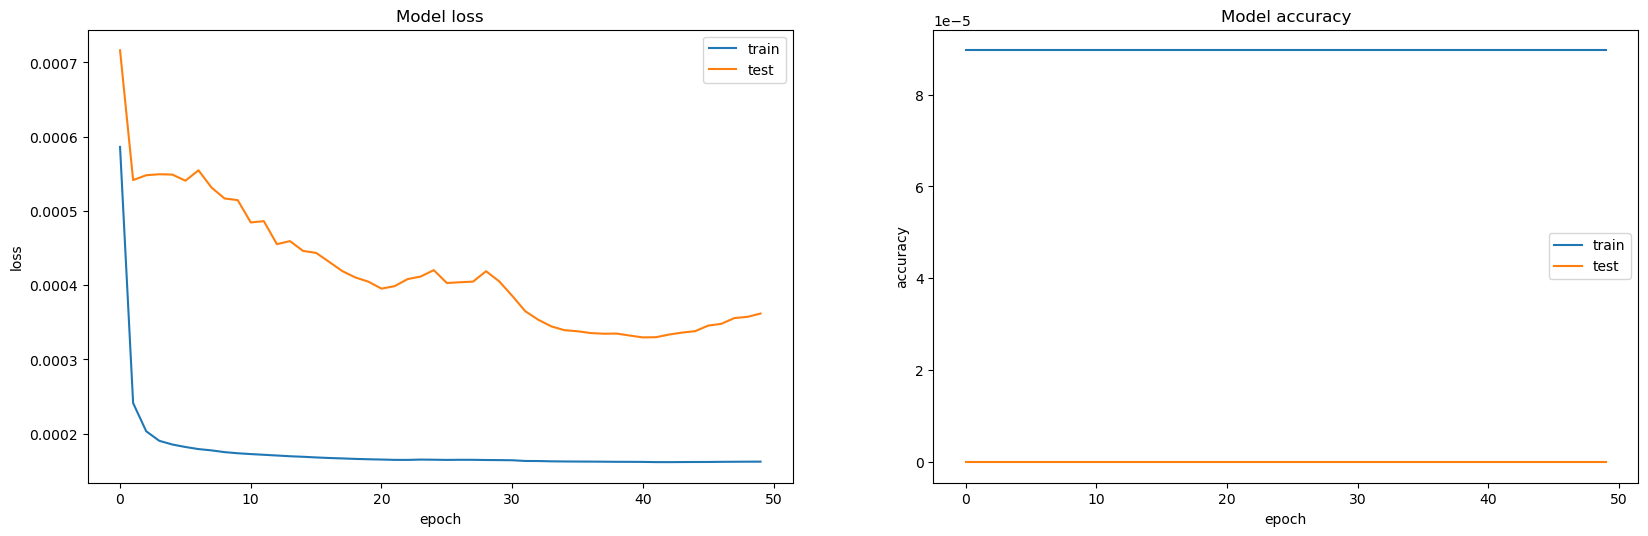

In [14]:
#datos_corregidos.loc[datos_corregidos.loc[:,"pm25_outlier"] != "N"]

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,6), dpi=100)
    
ax1.set_title("Model loss")
ax1.plot(history.history['loss'], label="train")
ax1.plot(history.history['val_loss'], label="test")
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax1.legend()
    
ax2.set_title("Model accuracy")
ax2.plot(history.history['accuracy'], label="train")
ax2.plot(history.history['val_accuracy'], label="test")
ax2.set_ylabel('accuracy')
ax2.set_xlabel('epoch')
ax2.legend()    
plt.show()

MSE Tendencia: 12.24632853827119
MSE RNN: 15.262894154925403


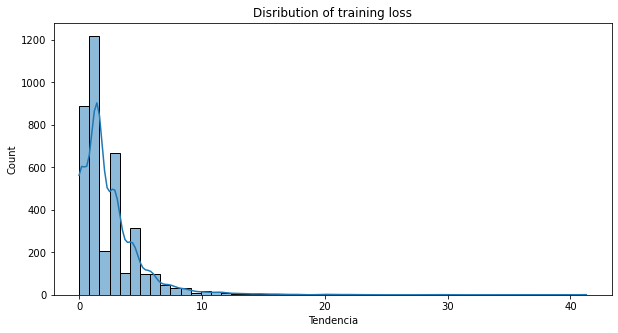

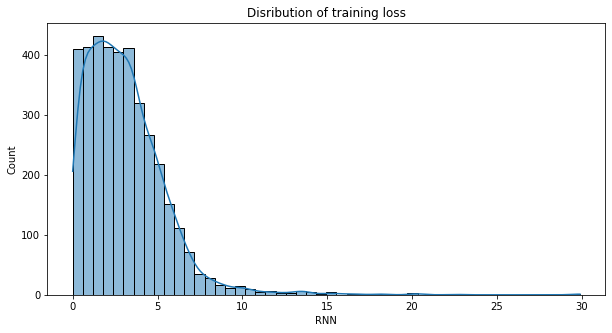

,count,mean,std,min,25%,50%,75%,max
Tendencia,3787.0,2.380099,2.565774,0.000000,1.108160,1.517760,2.987310,41.292800
RNN,3787.0,3.079526,2.404359,0.000116,1.391735,2.708954,4.263706,29.899938


In [15]:
corregidos = datos_corregidos.loc[datos_corregidos.loc[:,"pm25_outlier"] != "N"]
corregidos.reset_index(inplace=True, drop=True)

errores = pd.DataFrame(columns=["Tendencia","RNN"], dtype="float64")

for e in range (len(corregidos)):
    errores.loc[e,"Tendencia"] = abs(float(corregidos[sensor+"_outlier"][e])-float(corregidos[sensor+"_corr_ten"][e]))
    errores.loc[e,"RNN"] = abs(float(corregidos[sensor+"_outlier"][e])-float(corregidos[sensor+"_corr_RNN"][e]))

mse_ten = mean_squared_error(corregidos.pm25_outlier, corregidos.pm25_corr_ten)
mse_rnn = mean_squared_error(corregidos.pm25_outlier, corregidos.pm25_corr_RNN)
print("MSE Tendencia:",mse_ten)
print("MSE RNN:",mse_rnn)


plt.figure(figsize = (10,5))
sns.histplot(errores['Tendencia'], bins=50, kde=True);
plt.title('Disribution of training loss')


plt.figure(figsize = (10,5))
sns.histplot(errores['RNN'], bins=50, kde=True);
plt.title('Disribution of training loss')

plt.show()

errores.describe().transpose()


In [ ]:
# Threshold computation:




In [ ]:
# -*- coding: utf-8 -*-
"""Example of using Histogram- based outlier detection (HBOS) for
outlier detection
"""
# Author: Yue Zhao <zhaoy@cmu.edu>
# License: BSD 2 clause

from __future__ import division
from __future__ import print_function

import os
import sys

# temporary solution for relative imports in case pyod is not installed
# if pyod is installed, no need to use the following line
#sys.path.append(
#    os.path.abspath(os.path.join(os.path.dirname("__file__"), '..')))

from pyod.models.hbos import HBOS
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize



if __name__ == "__main__":
    contamination = 0.1  # percentage of outliers
    n_train = 200  # number of training points
    n_test = 100  # number of testing points

    # Generate sample data
    X_train, y_train, X_test, y_test = \
        generate_data(n_train=n_train,
                      n_test=n_test,
                      n_features=2,
                      contamination=contamination,
                      random_state=42)

    # train HBOS detector
    clf_name = 'HBOS'
    clf = HBOS()
    clf.fit(X_train)

    # get the prediction labels and outlier scores of the training data
    y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
    y_train_scores = clf.decision_scores_  # raw outlier scores

    # get the prediction on the test data
    y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
    y_test_scores = clf.decision_function(X_test)  # outlier scores

    # evaluate and print the results
    print("\nOn Training Data:")
    evaluate_print(clf_name, y_train, y_train_scores)
    print("\nOn Test Data:")
    evaluate_print(clf_name, y_test, y_test_scores)

    # visualize the results
    visualize(clf_name, X_train, y_train, X_test, y_test, y_train_pred,
              y_test_pred, show_figure=True, save_figure=False)

In [ ]:
X_train.shape
train_pred1.shape
train_pred.shape
prediccion
#train_loss
#y_train
#X_test
#y_test
#y_train_pred
#y_train_scores
#y_test_pred
#y_test_scores
#print("X_train",len(X_train))
#print("X_test",len(X_test))
#print("Suma X's",len(X_train)+len(X_test))
#print("y_train",len(y_train))
#print("y_train_scores",len(y_train_scores))
#plt.hist(clf.hist_)